# Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm, tqdm_notebook
from lvreml.data_prep import data_prep
from lvreml.lvreml import lvreml
from lvreml.initial_screen import initial_screen
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt

# Load data

In [2]:
# Expression Data
expr_file = 'C:\\Users\\ammar\\Documents\\YeastFiles\\SI_Data_01_expressionValues.txt'
df_expr = pd.read_table(expr_file)
print('Expression Data Shape',df_expr.shape)

# Genotype Data
geno_file = 'C:\\Users\\ammar\\Documents\\YeastFiles\\genotypes_binary_strongest_eqtl.csv'
df_geno = pd.read_csv(geno_file, index_col=0)
print('Genotype Data Shape',df_geno.shape)

# Covariates Data
cov_file = 'C:\\Users\\ammar\\Documents\\YeastFiles\\SI_Data_02_covariates.csv'
df_cov = pd.read_csv(cov_file) # pd.read_excel()
print('Covariates Data Shape',df_cov.shape)

Expression Data Shape (1012, 5720)
Genotype Data Shape (1012, 2884)
Covariates Data Shape (1012, 3)


In [3]:
# Perform confounders correction for covariates

In [4]:
cov = df_cov.values[:,1:3].astype(float) # covariates 
data_expr = df_expr.values.astype(float) # expression values
expr_corr = np.empty_like(data_expr) # empty matrix for corrected expression values

X = pd.DataFrame(cov, columns=['Batch','OD'])
for i in tqdm(range(data_expr.shape[1])):
    y = pd.DataFrame(data_expr[:,i], columns=['expr'])
    df = pd.concat([X,y],axis=1)
    reg = smf.ols(formula="expr ~ OD + C(Batch)", data=df).fit()
    expr_corr[:,i] = reg.resid

100%|█████████████████████████████████████████████████████████████████████████████| 5720/5720 [00:54<00:00, 104.22it/s]


In [5]:
df_expr_corr = pd.DataFrame(expr_corr.copy())
df_expr_corr.index = df_expr.index
df_expr_corr.columns = df_expr.columns

In [6]:
[Zn,S,V] = np.linalg.svd((df_geno.values - np.mean(df_geno.values, axis=0)),'econ')
vZ = (S**2)/np.sum(S**2)
C,_,Yn = data_prep(df_expr_corr.values,np.array([])) # Scale and normalize data using 'data_prep'
beta2,varexpl,idx = initial_screen(C,Zn,0,verbose=False)
vx = np.flip(np.argsort(varexpl))

C:\Users\ammar\Documents\GitHub\LVREML-Python\lvreml\data_prep.py:43: UserWarning: No covariates provided, assuming expression data is in format samples x genes
  warnings.warn("No covariates provided, assuming expression data is in format samples x genes")


# No. of inferred Hidden factors(SNPs) vs rho values

Text(0, 0.5, 'Gene expression variance explained')

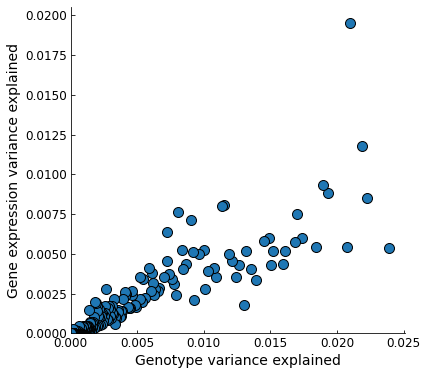

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(vZ,varexpl,'o', ms=10, mec='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((0.00, None))
ax.set_ylim((0.00, None))
ax.tick_params(direction="in", labelsize=12)
ax.set_xlabel('Genotype variance explained', fontsize=14)
ax.set_ylabel('Gene expression variance explained', fontsize=14)

In [8]:
def run_lvreml(theta,rho, flag):
    THET = np.empty((len(theta),len(rho)))
    LL = np.empty((len(theta),len(rho)))
    HID = np.empty((len(theta),len(rho)))
    RHO = np.empty((len(theta),len(rho)))
    if flag == 'expr': # use PCs of expression data as known covariate
        [Zn,S,V] = np.linalg.svd((df_expr_corr.values - np.mean(df_expr_corr.values, axis=0)),'econ')
    else: # use PCs of genotype data as known covariate
        [Zn,S,V] = np.linalg.svd((df_geno.values - np.mean(df_geno.values, axis=0)),'econ')
    C,_,Yn = data_prep(df_expr_corr.values,np.array([]))    
    beta2,varexpl,idx = initial_screen(C,Zn,0,verbose=False)
    vx = np.flip(np.argsort(varexpl))
    
    for i in range(len(theta)):
        Z = np.array([])
        if i > 0:
            Z = Zn[:,vx[0:theta[i]]]
        for j in range(len(rho)):
            X,alpha2,B,D,sigma2,K = lvreml(C,Z,rho[j])   
            D, V = np.linalg.eigh(K)
            Dinv = np.diag(1/D)
            t1 = np.sum(np.log(D))
            t2 = np.trace(np.dot(np.dot(np.dot(V,Dinv),V.T),C))
            LL[i,j] = -(t1+t2)
            HID[i,j] = X.shape[1]
            THET[i,j] = theta[i]
            RHO[i,j] = rho[j]
    return (THET, RHO, HID, LL)

# Targeted gene expression variance explained vs Number of inferred hidden covariates

C:\Users\ammar\Documents\GitHub\LVREML-Python\lvreml\data_prep.py:43: UserWarning: No covariates provided, assuming expression data is in format samples x genes
  warnings.warn("No covariates provided, assuming expression data is in format samples x genes")


no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 


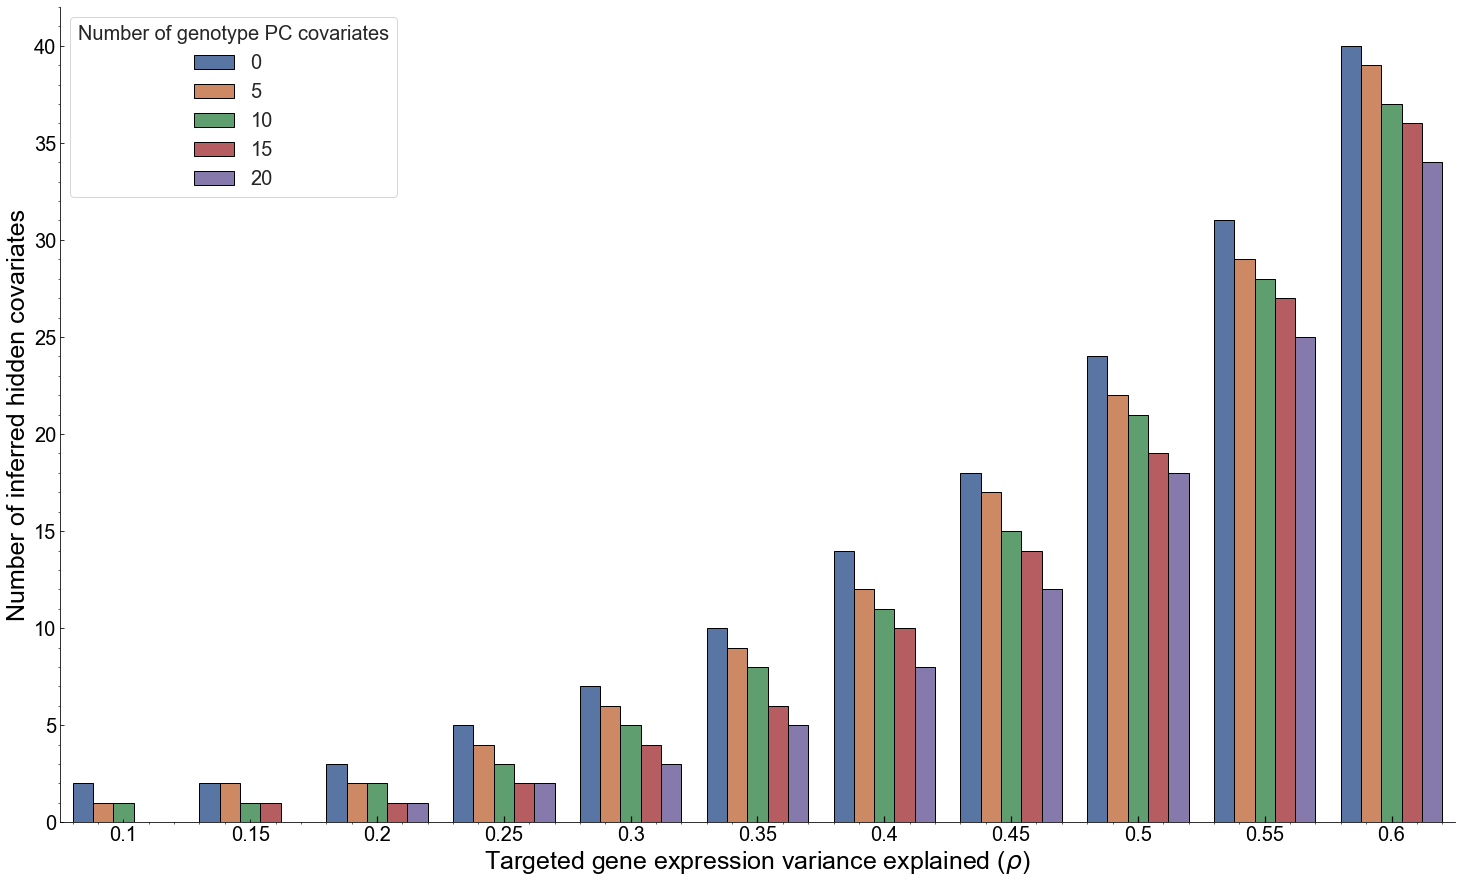

In [9]:
theta =  np.arange(0,25,5) # No. of known factors
rho = np.arange(0.1,0.65,0.05) # gene expression variance explained

THET, RHO, HID, LL = run_lvreml(theta,rho, flag='geno')

df1 = pd.DataFrame(THET.flatten()) 
df2 = pd.DataFrame(HID.flatten())
df3 = pd.DataFrame(np.round(RHO,3).flatten())
df4 = pd.DataFrame(LL.flatten())
df = pd.concat([df1, df2,df3,df4], axis=1)
fig, ax = plt.subplots(figsize=(25,15))
labels = [x + '' for x in theta.astype(str)]
sns.set(style="whitegrid")
df.columns = ['theta','hidden','rho','ll']
ax = sns.barplot(x='rho', y='hidden', hue='theta', data=df, edgecolor='black')
#ax.tick_params(axis='both',labelsize='20')
ax.xaxis.label.set_fontsize(25)
ax.yaxis.label.set_fontsize(25)
#ax.set_title('Targeted gene expression variance explained ($\\rho$)', fontsize=25)
ax.set_xlabel('Targeted gene expression variance explained ($\\rho$)', fontsize=25)
ax.set_ylabel('Number of inferred hidden covariates', fontsize=25)
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, fontsize=20, title="Number of genotype PC covariates", title_fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(direction="in", labelsize=20)
# plt.grid(which='major')
# plt.grid(which='minor')
plt.minorticks_on()

# Log-Likelihood plots

no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
Inferring desired number of latent variables: 5
Inferring desired number of latent variables: 15
Inferring desired number of latent variables: 25
Inferring desired number o

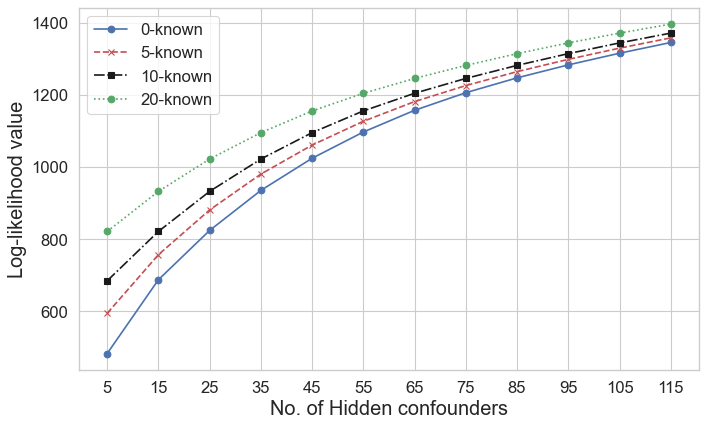

In [10]:
theta =  np.array([0,5,10,20]) # No. of known factors
rho = np.arange(5,120,10) # No. of hidden factors

THET, RHO, HID, LL = run_lvreml(theta,rho, flag='expr')

plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
col = ['-bo','--rx','-.ks',':go']

for i in range(len(theta)):
    plt.plot(HID[i,:],LL[i,:],col[i])
    
    labels = [x + '-known' for x in theta.astype(str)]    
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.minorticks_on()
    plt.ylabel('Log-likelihood value',fontsize=18)
    plt.xlabel('No. of Hidden confounders',fontsize=18)
    plt.xticks(rho,fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(labels, fontsize=15)

C:\Users\ammar\Documents\GitHub\LVREML-Python\lvreml\data_prep.py:43: UserWarning: No covariates provided, assuming expression data is in format samples x genes
  warnings.warn("No covariates provided, assuming expression data is in format samples x genes")


no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
Inferring desired number of latent variables: 5
Inferring desired number of latent variables: 15
Inferring desired number of latent variables: 25
Inferring desired number o

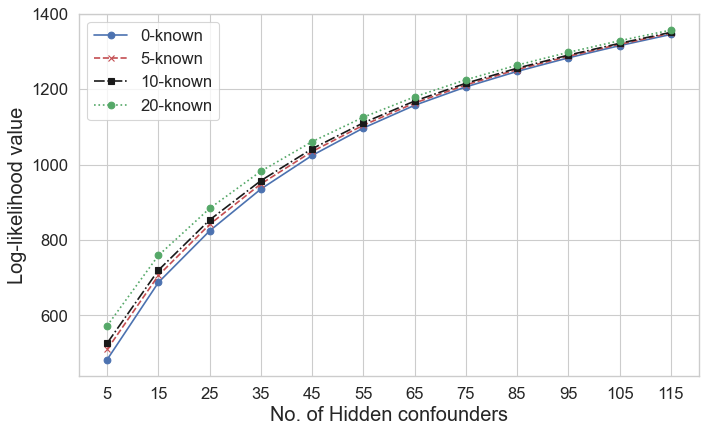

In [11]:
theta =  np.array([0,5,10,20]) # No. of known factors
rho = np.arange(5,120,10) # No. of hidden factors

THET, RHO, HID, LL = run_lvreml(theta,rho, flag='geno')

plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
col = ['-bo','--rx','-.ks',':go']

for i in range(len(theta)):
    plt.plot(HID[i,:],LL[i,:],col[i])
    
    labels = [x + '-known' for x in theta.astype(str)]    
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.minorticks_on()
    plt.ylabel('Log-likelihood value',fontsize=18)
    plt.xlabel('No. of Hidden confounders',fontsize=18)
    plt.xticks(rho,fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(labels, fontsize=15)